In [1]:
import pandas as pd 
import spacy

In [2]:
phab_path = "/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case1/0312_resolved_ve_phab_comments.csv"
phab_df = pd.read_csv(phab_path)

In [3]:
#find gerrit phab PHID: PHID-USER-idceizaw6elwiwm5xshb
phab_df['isGerrit'] = phab_df['AuthorPHID'] == 'PHID-USER-idceizaw6elwiwm5xshb'
#cleaning df
phab_df['id'] = phab_df.index + 1
#may have to build out the reply_to column 
phab_df['reply_to'] = phab_df.groupby('TaskPHID')['id'].shift()
phab_df['reply_to'] = phab_df['reply_to'].where(pd.notnull(phab_df['reply_to']), None)

phab_df = phab_df.rename(columns={
    'AuthorPHID': 'speaker',
    'TaskPHID': 'conversation_id',
    'WMFaffil':'meta.affil',
    'isGerrit': 'meta.gerrit'
})

# after 11-1-2012 before 11-1-2013
phab_df['timestamp'] = pd.to_datetime(phab_df['date_created'], unit='s', origin='unix', utc=True)
filtered_phab_df = phab_df[(phab_df['date_created'] < 1383264000) & (phab_df['date_created'] > 1351728000)]

#removing headless conversations
task_phab_df = filtered_phab_df[filtered_phab_df['comment_type']=="task_description"]
headed_task_phids = task_phab_df['conversation_id'].unique()
filtered_phab_df = filtered_phab_df[filtered_phab_df['conversation_id'].isin(headed_task_phids)]

#removing gerrit comments 
comment_phab_df = filtered_phab_df[filtered_phab_df['meta.gerrit'] != True]

In [4]:
unique_conversation_ids = len(comment_phab_df['conversation_id'].unique())
unique_ids = len(comment_phab_df['id'].unique())
unique_speakers = len(comment_phab_df['speaker'].unique())

print(f"Unique conversation_ids: {unique_conversation_ids}")
print(f"Unique ids: {unique_ids}")
print(f"Unique speakers: {unique_speakers}")

Unique conversation_ids: 2081
Unique ids: 8804
Unique speakers: 230


In [5]:
import re

def preprocess_text(text):
    text = str(text)
    text = text.replace('*', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'http\S+', '', text)
    return text

In [6]:
comment_phab_df['processed_text'] = comment_phab_df['text'].apply(preprocess_text)

/tmp/ipykernel_32320/3649688126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['processed_text'] = comment_phab_df['text'].apply(preprocess_text)


In [7]:
comment_phab_df['processed_resolved_text'] = comment_phab_df['resolved_text'].apply(preprocess_text)

/tmp/ipykernel_32320/1316816771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['processed_resolved_text'] = comment_phab_df['resolved_text'].apply(preprocess_text)


In [17]:
nlp = spacy.load("en_core_web_sm")

def extract_dependency_tree(text):
    doc = nlp(text)
    dependency_trees = []
    
    for sentence in doc.sents:
        for token in sentence:
            token_info = (
                token.text, 
                token.lemma_, 
                token.dep_, 
                token.head.text, 
                list(token.ancestors), 
                list(token.subtree), 
                list(token.children)
            )
            dependency_trees.append(token_info)
        
    return dependency_trees

In [18]:
comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)

/tmp/ipykernel_32320/2805711855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)


In [19]:
comment_phab_df['resolved_dependency_tree'] = comment_phab_df['processed_resolved_text'].apply(extract_dependency_tree)

/tmp/ipykernel_32320/2117289791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['resolved_dependency_tree'] = comment_phab_df['processed_resolved_text'].apply(extract_dependency_tree)


In [20]:
#get VAD scores
import numpy as np
#https://saifmohammad.com/WebPages/nrc-vad.html
column_headings = ['Word', 'Valence', 'Arousal', 'Domination']
vad_lexicon = pd.read_csv('NRC-VAD-Lexicon.txt', delimiter='\t', header=None, names=column_headings)
vad_dict = vad_lexicon.set_index('Word').T.to_dict()

def vad_scoring(dependency_tree):
    valence = []
    arousal = []
    dominance = []
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            valence.append(vad_dict[lemma]['Valence'])
            arousal.append(vad_dict[lemma]['Arousal'])
            dominance.append(vad_dict[lemma]['Domination'])

    # Compute average scores across the comment
    avg_valence = np.mean(valence) if valence else 0
    avg_arousal = np.mean(arousal) if arousal else 0
    avg_dominance = np.mean(dominance) if dominance else 0

    return [avg_valence, avg_arousal, avg_dominance]

def dominance_prevail(dependency_tree):
    dominant_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Domination'] >= 0.75:
                dominant_words += 1
    return dominant_words

def arousal_prevail(dependency_tree):
    arousal_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Arousal'] >= 0.75:
                arousal_words += 1
    return arousal_words
    

In [21]:
#establishing per-comment VAD scores 
comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
comment_phab_df['arousal_wc'] = comment_phab_df['dependency_tree'].apply(arousal_prevail)

/tmp/ipykernel_32320/2150736954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
/tmp/ipykernel_32320/2150736954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
/tmp/ipykernel_32320/2150736954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [22]:
comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
comment_phab_df = comment_phab_df.drop(columns=['avg_vad_scores'])

/tmp/ipykernel_32320/335308388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
/tmp/ipykernel_32320/335308388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
/tmp/ipykernel_32320

In [79]:
# expand the dependency parser 

#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
pattern = r'\b(bots|scripts|gadgets)\b'

dependency_relations = []
resolved_dependency_relations = []

for index, row in comment_phab_df.iterrows():
    text = row['text']
    timestamp = row['timestamp']
    comment_id = row['id']
    conversation_id = row['conversation_id']
    WMFaffil = row['meta.affil']
    
    for token, lemma, dep, head, ancestors, subtree, children in row['dependency_tree']:
        if re.search(pattern, token, re.IGNORECASE):
            dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })
    for token, lemma, dep, head, ancestors, subtree, children in row['resolved_dependency_tree']:
        if re.search(pattern, token, re.IGNORECASE):
            resolved_dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })

resolved_dependency_relations_df = pd.DataFrame(resolved_dependency_relations)            
dependency_relations_df = pd.DataFrame(dependency_relations)

In [25]:
#now analysis/plotting 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

/tmp/ipykernel_32320/3133046381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_phab_df['first_comment'] = task_phab_df.groupby('speaker')['timestamp'].rank(method='first') <= 5
/tmp/ipykernel_32320/3133046381.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time


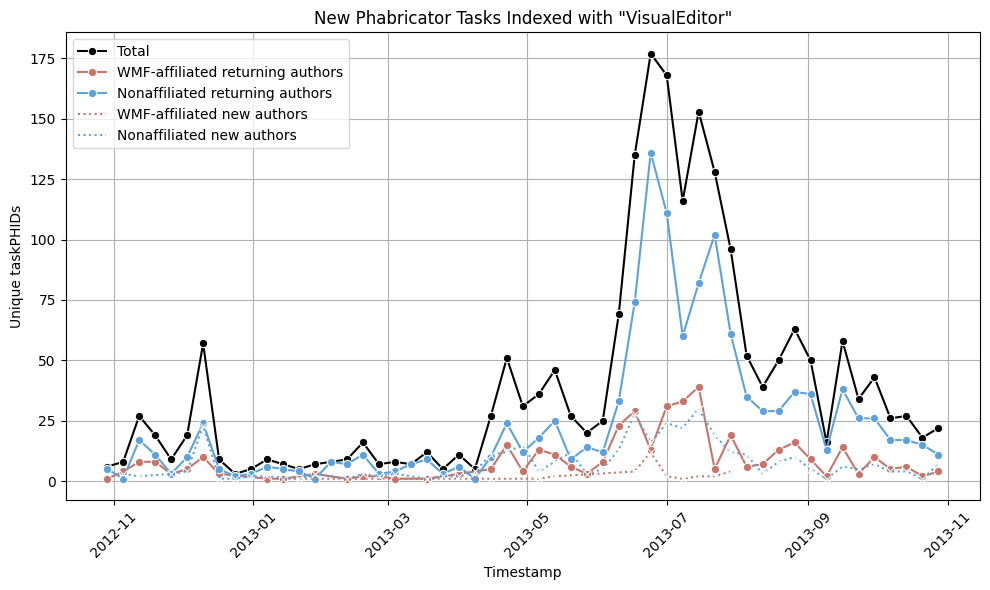

In [38]:
plt.figure(figsize=(10, 6))
task_phab_df = phab_df[phab_df['comment_type']=="task_description"]
task_phab_df['first_comment'] = task_phab_df.groupby('speaker')['timestamp'].rank(method='first') <= 5
task_phab_df = task_phab_df[(task_phab_df['date_created'] < 1383264000) & (task_phab_df['date_created'] > 1351728000)]

task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time
unique_taskPHIDs = task_phab_df.groupby('week')['conversation_id'].nunique()

wmf_task_phab_df = task_phab_df[(task_phab_df['first_comment'] != True) & (task_phab_df['meta.affil'] == True)]
wmf_tasks = wmf_task_phab_df.groupby('week')['conversation_id'].nunique()

other_task_phab_df = task_phab_df[(task_phab_df['first_comment'] != True) & (task_phab_df['meta.affil'] != True)]
other_tasks = other_task_phab_df.groupby('week')['conversation_id'].nunique()

unaff_new_tasks_phab_df = task_phab_df[(task_phab_df['first_comment'] == True) & (task_phab_df['meta.affil'] != True)]
unaff_new_tasks = unaff_new_tasks_phab_df.groupby('week')['conversation_id'].nunique()

aff_new_tasks_phab_df = task_phab_df[(task_phab_df['first_comment'] == True) & (task_phab_df['meta.affil'] == True)]
aff_new_tasks = aff_new_tasks_phab_df.groupby('week')['conversation_id'].nunique()

sns.lineplot(x=unique_taskPHIDs.index, y=unique_taskPHIDs.values, color='black', label='Total', marker='o')
sns.lineplot(x=wmf_tasks.index, y=wmf_tasks.values, color='#c7756a', label='WMF-affiliated returning authors', marker='o')
sns.lineplot(x=other_tasks.index, y=other_tasks.values, color='#5da2d8', label='Nonaffiliated returning authors', marker='o')
sns.lineplot(x=aff_new_tasks.index, y=aff_new_tasks.values, color='#c7756a',linestyle="dotted", label="WMF-affiliated new authors", marker='x')
sns.lineplot(x=unaff_new_tasks.index, y=unaff_new_tasks.values, color='#5da2d8', linestyle="dotted", label="Nonaffiliated new authors", marker='x')

plt.title('New Phabricator Tasks Indexed with "VisualEditor"')
plt.xlabel('Timestamp')
plt.ylabel('Unique taskPHIDs')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

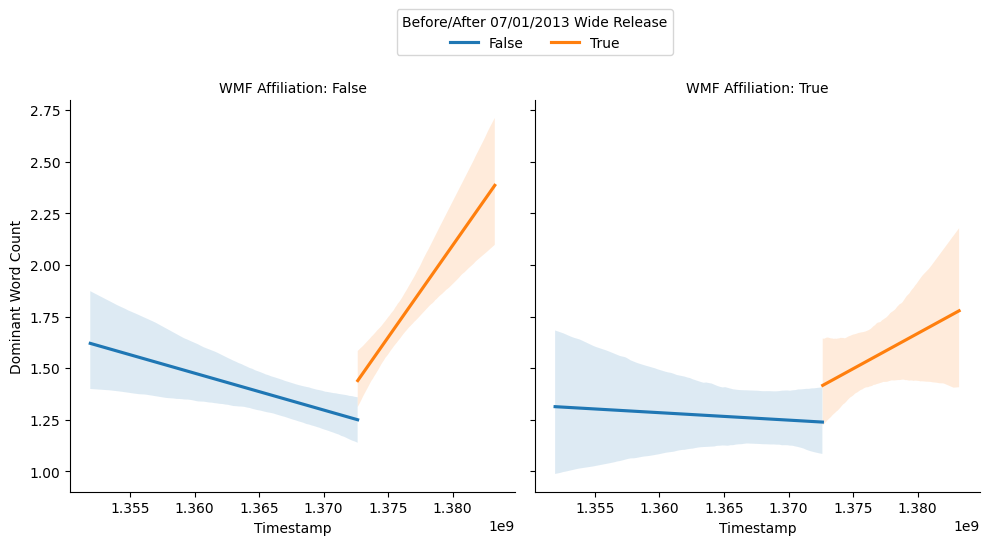

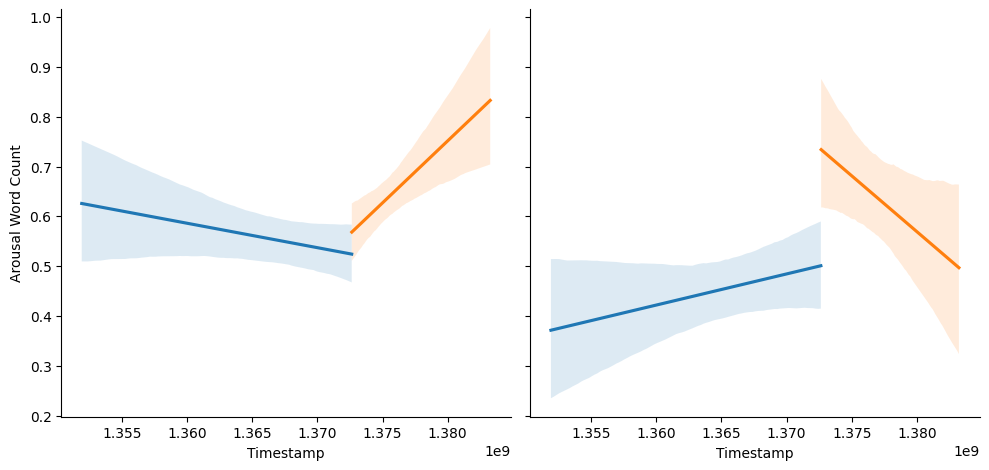

In [61]:
comment_phab_df['before_after'] = comment_phab_df['timestamp'] > pd.Timestamp('2013-07-01 00:00:01+00:00')
plt.figure(figsize=(10, 6))

# Plot for dominant_wc
plot1 = sns.lmplot(data=comment_phab_df, x="date_created", y="dominant_wc", hue="before_after", col="meta.affil", scatter=False, legend=False)
plot1.set_axis_labels("Timestamp", "Dominant Word Count")
plot1.set_titles(col_template="WMF Affiliation: {col_name}")
plot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
#plot1.add_legend(title="Before/After 07/01/2013 Wide Release")
plt.legend(title="Before/After 07/01/2013 Wide Release", loc='upper center', bbox_to_anchor=(0, 1.25), ncol=2)
# Plot for arousal_wc
plot2 = sns.lmplot(data=comment_phab_df, x="date_created", y="arousal_wc", hue="before_after", col="meta.affil", scatter=False, legend=False)
plot2.set_axis_labels("Timestamp", "Arousal Word Count")
plot2.set_titles("")
#plot2.add_legend(title="Before/After 07/01/2013 Wide Release")

# Show plots
plt.show()

/tmp/ipykernel_32320/1234247344.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
/tmp/ipykernel_32320/1234247344.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]
/tmp/ipykernel_32320/1234247344.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_32320/1234247344.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

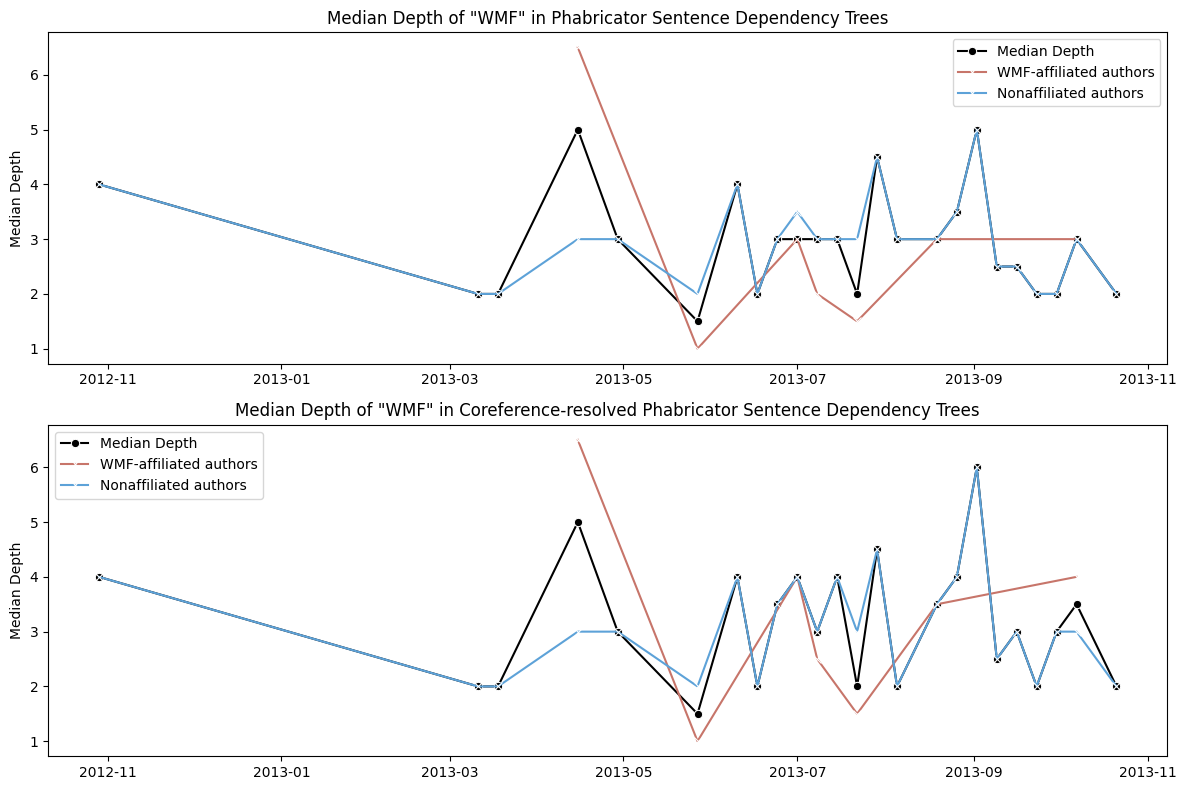

In [80]:
#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(bots)\b'
filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]

plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[6, 6])

# Main plot: Token depth by timestamp
'''
ax0 = plt.subplot(gs[0])
sns.scatterplot(data=filtered_dependencies, x='timestamp', y='dependency', hue='wmfAffil', style='dependency', markers=True, s=100, ax=ax0)
ax0.set_title('VE Depth by Timestamp w/o URLS')
ax0.set_xlabel('')
ax0.set_ylabel('Dependency Type')
ax0.legend().set_visible(False)
'''
# Calculate the median depth over time
filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
median_depth = filtered_dependencies.groupby('week')['depth'].median().reset_index()

wmf_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] == True]
wmf_median_depth = wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

other_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] != True]
other_median_depth = other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax0 = plt.subplot(gs[0])
sns.lineplot(data=median_depth, x='week', y='depth', ax=ax0, color='black', label='Median Depth', marker='o')
sns.lineplot(data=wmf_median_depth, x='week', y='depth', ax=ax0, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.lineplot(data=other_median_depth, x='week', y='depth', ax=ax0, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax0.set_title('Median Depth of "WMF" in Phabricator Sentence Dependency Trees')
ax0.set_ylabel('Median Depth')
ax0.set_xlabel('')

# Calculate the median depth over time
resolved_filtered_dependencies['week'] = resolved_filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
resolved_median_depth = resolved_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_wmf_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] == True]
resolved_wmf_median_depth = resolved_wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_other_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] != True]
resolved_other_median_depth = resolved_other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax1 = plt.subplot(gs[1])
sns.lineplot(data=resolved_median_depth, x='week', y='depth', ax=ax1, color='black', label='Median Depth', marker='o')
sns.lineplot(data=resolved_wmf_median_depth, x='week', y='depth', ax=ax1, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.lineplot(data=resolved_other_median_depth, x='week', y='depth', ax=ax1, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax1.set_title('Median Depth of "WMF" in Coreference-resolved Phabricator Sentence Dependency Trees')
ax1.set_ylabel('Median Depth')
ax1.set_xlabel('')

plt.tight_layout()
plt.show()